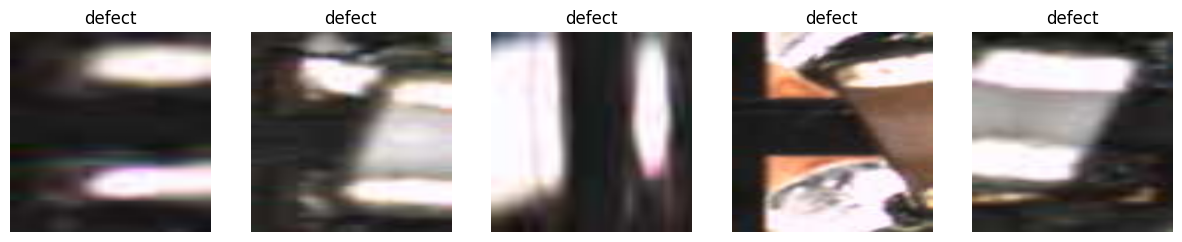

Total training samples: 172
Shape of first image: torch.Size([3, 224, 224])
Total testing samples: 121
Shape of first test image: torch.Size([3, 224, 224])


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:06<00:00, 93.3MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

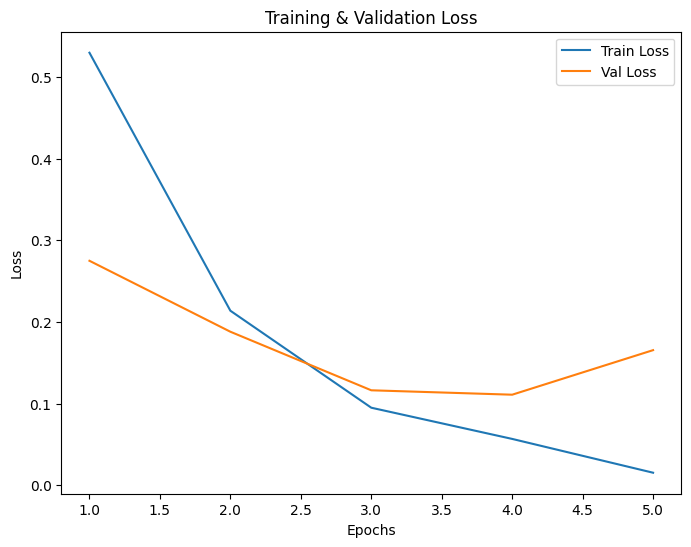

Test Accuracy: 0.9504
Name: THIRUMALAI K
Register Number: 212224240176


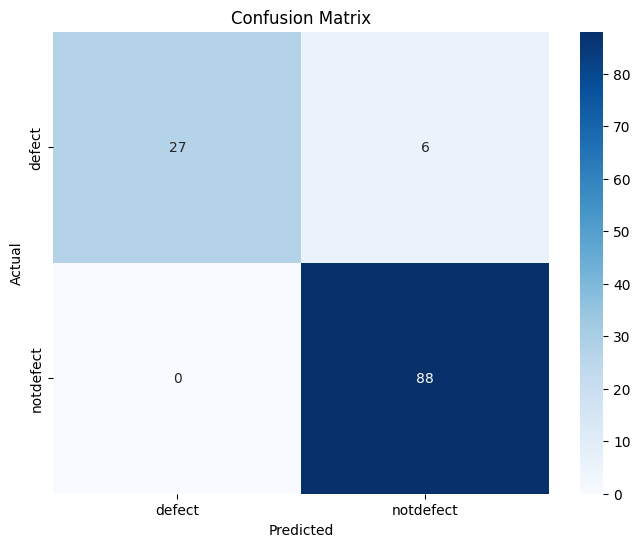

Classification Report:
              precision    recall  f1-score   support

      defect       1.00      0.82      0.90        33
   notdefect       0.94      1.00      0.97        88

    accuracy                           0.95       121
   macro avg       0.97      0.91      0.93       121
weighted avg       0.95      0.95      0.95       121



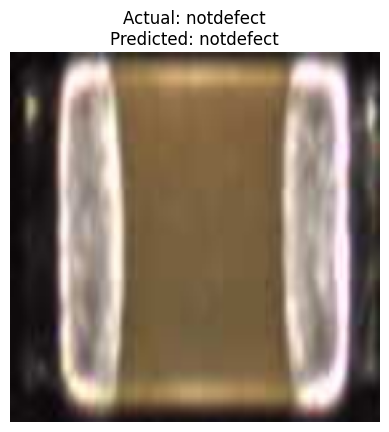

Actual: notdefect, Predicted: notdefect


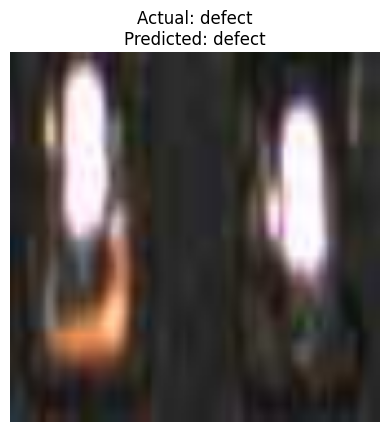

Actual: defect, Predicted: defect


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models, datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os

## Step 1: Load and Preprocess Data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Uncomment this if using ImageNet-pretrained models
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ⚠️ If running in Colab, use unzip — otherwise extract manually
# !unzip -qq ./chip_data.zip -d data  ← ❌ REMOVE this line for Python scripts

dataset_path = "/content/data"
train_dataset = datasets.ImageFolder(root="/content/data/dataset/train", transform=transform)
test_dataset = datasets.ImageFolder(root="/content/data/dataset/test", transform=transform)

# Show sample images
def show_sample_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)
        axes[i].imshow(image)
        axes[i].set_title(dataset.classes[label])
        axes[i].axis("off")
    plt.show()

show_sample_images(train_dataset)

print(f"Total training samples: {len(train_dataset)}")
print(f"Shape of first image: {train_dataset[0][0].shape}")
print(f"Total testing samples: {len(test_dataset)}")
print(f"Shape of first test image: {test_dataset[0][0].shape}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Step 2: Load Pretrained Model & Modify
model = models.vgg19(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace final classifier layer
num_classes = len(train_dataset.classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# Now unfreeze classifier parameters only
for param in model.classifier.parameters():
    param.requires_grad = True

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

from torchsummary import summary
summary(model, input_size=(3, 224, 224))

# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

## Step 3: Train the Model
def train_model(model, train_loader, test_loader, num_epochs=5):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Plot loss curves
    print("Name: THIRUMALAI K")
    print("Register Number: 212224240176")
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.show()


# ✅ Now Train
train_model(model, train_loader, test_loader, num_epochs=5)

## Step 4: Test the Model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    print("Name: THIRUMALAI K")
    print("Register Number: 212224240176")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=train_dataset.classes,
                yticklabels=train_dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# ✅ Evaluate
test_model(model, test_loader)

## Step 5: Predict on a single image
def predict_image(model, image_index, dataset):
    model.eval()
    image, label = dataset[image_index]
    image_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)

    class_names = dataset.classes
    image_to_display = transforms.ToPILImage()(image)
    plt.imshow(image_to_display)
    plt.title(f"Actual: {class_names[label]}\nPredicted: {class_names[predicted.item()]}")
    plt.axis('off')
    plt.show()

    print(f"Actual: {class_names[label]}, Predicted: {class_names[predicted.item()]}")

# ✅ Run Prediction
predict_image(model, image_index=55, dataset=test_dataset)
predict_image(model, image_index=25, dataset=test_dataset)

In [4]:
!unzip -qq chip_data.zip -d data/